In [1]:
import numpy as np

In [2]:
from folder import ImageFolder
THRESHOLD = 1

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.models as models

class EmbeddingNet(nn.Module):
    def __init__(self, resnet = None):
        super(EmbeddingNet, self).__init__()
        if resnet is None:
            resnet = models.resnet18(pretrained=True)
            
        self.resnet = resnet
        self.resnet_layer = self.resnet._modules.get('avgpool')
        self.resnet.eval()

        self.fc = nn.Sequential(nn.Linear(64 * 8, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )
    def forward(self, x):
        output = self.get_resnet_embedding(x)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)
    
    def get_resnet_embedding(self, x):
        embedding = torch.cuda.FloatTensor(x.shape[0],512,1,1).fill_(0)
        def copy(m, i, o):
            embedding.copy_(o.data)
        hook = self.resnet_layer.register_forward_hook(copy)
        self.resnet(x)
        hook.remove()
        return embedding.view(embedding.size()[0], -1)

In [4]:
from torchvision import transforms
classes = None
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

data = ImageFolder('./Flickr', transform=transform,classes=classes)
data_untransformed = ImageFolder('./Flickr', classes=classes)
print("{} images encompassing {} classes".format(len(data), len(data.classes)))

269648 images encompassing 704 classes


In [6]:
from sklearn.preprocessing import binarize
embedding_net = EmbeddingNet()
test = data[0][0][None,:,:,:]
embedding = embedding_net.get_resnet_embedding(test).cpu().numpy()
binarize(embedding, threshold=THRESHOLD)

array([[0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 

In [7]:
# Cuda
cuda = torch.cuda.is_available()
if cuda:
    embedding_net.cuda()

In [8]:
# Model
from sklearn.neighbors import NearestNeighbors
import numpy as np
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree')

In [9]:
# Binarization
from sklearn.preprocessing import binarize

In [10]:
# Batch Size, Workers, Data Loader
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, **kwargs)

In [11]:
def binarize_data(embedding_net, model, data_loader, threshold, step=10):
    binarized_outputs = []
    for batch_idx, (data, target) in enumerate(data_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()
        outputs = embedding_net.get_resnet_embedding(*data)
        outputs = binarize(outputs, threshold=threshold)
        binarized_outputs = binarized_outputs + list(outputs)
        if not (batch_idx % step):
            print("Batch {}".format(batch_idx))
    print("Finishing binarized data.")
    model.fit(binarized_outputs)
    print("Finished fitting data.")
    return model

In [12]:
model = binarize_data(embedding_net, nbrs, data_loader, THRESHOLD, step = 100)

Batch 0
Batch 100
Batch 200
Batch 300
Batch 400
Batch 500
Batch 600
Batch 700
Batch 800
Batch 900
Batch 1000
Batch 1100
Batch 1200
Batch 1300
Batch 1400
Batch 1500
Batch 1600
Batch 1700
Batch 1800
Batch 1900
Batch 2000
Batch 2100


In [34]:
import matplotlib.pyplot as plt
def search(model, n=5, index=None):
    embedding_net = EmbeddingNet()
    if index is None:
        test_idx = np.random.randint(0,len(data))
    else:
        test_idx = index
    test = data[test_idx][0][None,:,:,:]
    embedding = embedding_net.get_resnet_embedding(test).cpu().numpy()
    binary_embedding = binarize(embedding, threshold=THRESHOLD)
    distances, neighbors = model.kneighbors(binary_embedding, n)
    results = []
    for i in neighbors[0]:
        results.append(data_untransformed[i])
        
    print("Median distance: {}".format(np.median(distances)))
    print("Mean distance: {}".format(np.mean(distances)))
    
    plt.figure()
    plt.title("Search Query: Index {}".format(test_idx))
    plt.imshow(data_untransformed[test_idx][0])
    
    for i in range(len(results)):
        plt.figure()
        plt.title("Search Result {}".format(i+1))
        plt.ylabel(data.classes[results[i][1]])
        plt.xlabel(distances[0][i])
        plt.imshow(results[i][0])


Median distance: 11.575836902790225
Mean distance: 9.242670596231239


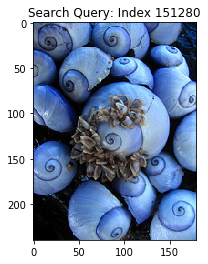

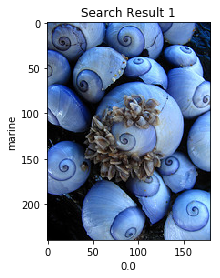

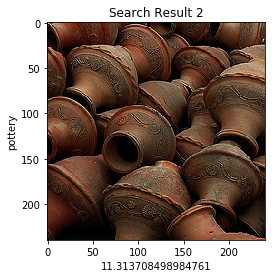

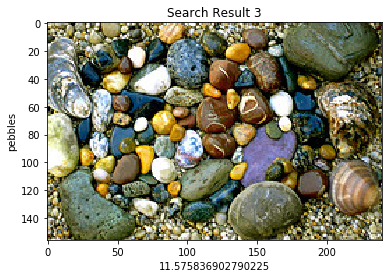

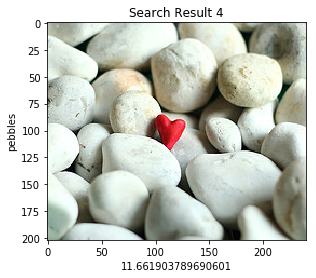

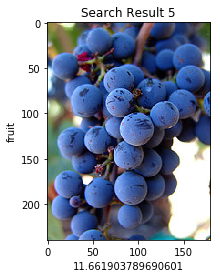

In [42]:
#cat 45600
#crab 68000

search(model, index=None, n=5)